In [2]:
'''
Author: SongZihui-sudo 1751122876@qq.com
Date: 2024-07-08 16:05:04
LastEditors: SongZihui-sudo 1751122876@qq.com
LastEditTime: 2024-07-08 21:16:56
FilePath: /deeplearning/NiN.ipynb
Description: 这是默认设置,请设置`customMade`, 打开koroFileHeader查看配置 进行设置: https://github.com/OBKoro1/koro1FileHeader/wiki/%E9%85%8D%E7%BD%AE
'''
import torch
import torchvision
import tqdm
import matplotlib.pyplot as plt

In [3]:
# 使用 GPU
def try_gpu(i=0):  #@save
    """如果存在，则返回gpu(i)，否则返回cpu()"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

def try_all_gpus():  #@save
    """返回所有可用的GPU，如果没有GPU，则返回[cpu(),]"""
    devices = [torch.device(f'cuda:{i}')
             for i in range(torch.cuda.device_count())]
    return devices if devices else [torch.device('cpu')]

In [4]:
# 数据预处理, 调整图片大小
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Resize([224, 224])])

# 下载Fashion-MNIST训练集数据，并构建训练集数据载入器trainloader,每次从训练集中载入64张图片，每次载入都打乱顺序
trainset = torchvision.datasets.FashionMNIST('dataset/', download=False, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# 下载Fashion-MNIST测试集数据，并构建测试集数据载入器trainloader,每次从测试集中载入64张图片，每次载入都打乱顺序
testset = torchvision.datasets.FashionMNIST('dataset/', download=False, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [84]:
def make_net(cfg):
   layers = []
   pre = 1
   for config in cfg:
      if config == "M":
         layers.append(torch.nn.MaxPool2d(kernel_size=3, stride=2))
      elif config == "D":
         layers.append(torch.nn.Dropout(0.5))
      else:
         block = []
         for i in range(config["num_layers"]):
            if i:
               block.append(torch.nn.Conv2d(pre, 
                                          config["num_channels"], 
                                          kernel_size=1))
            else:
               block.append(torch.nn.Conv2d(pre, 
                                          config["num_channels"], 
                                          kernel_size=config["kernel_size"], 
                                          stride=config["strides"], 
                                          padding=config["padding"]))
            block.append(torch.nn.ReLU())
            pre = config["num_channels"]
         layers.append(torch.nn.Sequential(*block))
   return torch.nn.Sequential(*layers)

In [85]:
class NiN(torch.nn.Module):
    def __init__(self, cfg):
        super(NiN, self).__init__()
        
        self.blocks = make_net(cfg)
        self.output = torch.nn.Sequential(torch.nn.AdaptiveAvgPool2d((1, 1)), torch.nn.Flatten())
        
    def forward(self, x):
        x = self.blocks(x)
        x = self.output(x)
        return x

In [86]:
cfg = {
    "NiN": [
        {
            "kernel_size": 11,
            "num_channels": 96,
            "strides" : 4,
            "padding": 0,
            "num_layers": 3
        },
        "M",
        {
            "kernel_size": 5,
            "num_channels": 256,
            "strides" : 1,
            "padding": 1,
            "num_layers": 3
        },
        "M",
        {
            "kernel_size": 3,
            "num_channels": 384,
            "strides" : 1,
            "padding": 1,
            "num_layers": 3
        },
        "M",
        "D",
        {
            "kernel_size": 3,
            "num_channels": 10,
            "strides" : 1,
            "padding": 1,
            "num_layers": 3
        }
    ]
}

In [87]:
net = NiN(cfg["NiN"])
net = net.to(device=try_gpu())

print(net)

net.train()

cost = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters())

loss_data = {
    "epoch" : [],
    "loss" : []
}

i = 0
for epoch in tqdm.tqdm(range(10)):
    loss_sum = 0
    for images, labels in trainloader:
        images = images.to(device=try_gpu())
        labels = labels.to(device=try_gpu())
        y_predict = net(images)
        optimizer.zero_grad()
        loss = cost( y_predict, labels )
        loss.backward()
        optimizer.step()
        i = i + 1
        loss_sum = loss_sum + float(loss)
    loss_data["epoch"].append(epoch)
    loss_data["loss"].append(loss_sum / i)
    i = i + 1

NiN(
  (blocks): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4))
      (1): ReLU()
      (2): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
      (3): ReLU()
      (4): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
      (5): ReLU()
    )
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Sequential(
      (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
      (3): ReLU()
      (4): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
      (5): ReLU()
    )
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(384, 384, kernel_size=(1, 1), stride=(1, 1))
      (3): ReLU()
      (4): Conv2d(384, 384, kernel_size=(1, 1), stride

100%|██████████| 10/10 [20:05<00:00, 120.52s/it]


{'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'loss': [1.3100457547315911, 0.3531776337815398, 0.1892506626371125, 0.12225612973404947, 0.08860057873018863, 0.06913390738458716, 0.05517516045519947, 0.04521151802389366, 0.03771486343540383, 0.03166521642313863]}


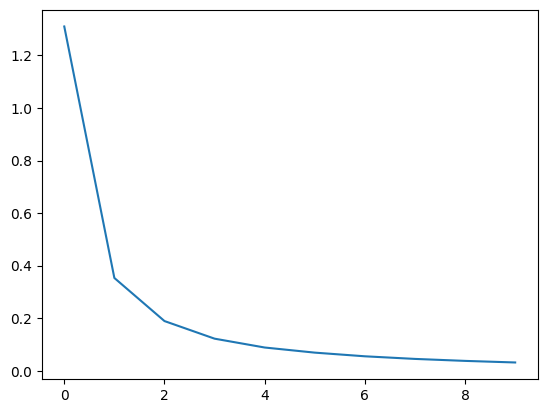

In [91]:
print(loss_data)
plt.plot(loss_data["epoch"], loss_data["loss"])
plt.show()

In [92]:
net.eval()
yhat = []
epoch = 0
accuracy_sum = 0
for images, labels in testloader:
    images = images.to(device=try_gpu())
    labels = labels.to(device=try_gpu())
    y_predict = net(images)
    y_predict = torch.argmax(y_predict, dim = 1)
    accuracy = torch.eq(labels, y_predict).float().mean()
    accuracy_sum = accuracy_sum + accuracy
    epoch = epoch + 1
print("平均精准度：%f" % (accuracy_sum / epoch))

平均精准度：0.879080
